# Lab 6: Image Compression

Compression is a rich topic of study in itself which relates to ideas within this course as well as ideas in probability. In particular, if you find this lab interesting, you may consider taking an Information Theory course at some point. 

This lab will allow you to apply some of the concepts and techniques that you have learned over the course of the quarter to the application of image compression. We'll start by looking at various ways that we can reduce the size of an image by a half, while maintaining reasonable visual fidelity to the original image. Some of these methods will prove to be much better than others. We will build off of the most successful approaches to create a general method that actually allows us to reduce the size of an image by much more than a half, without sacrificing appearance. 

The initial sections of the lab are a guided tour to help reinforce ideas from the course and introduce new ideas pertaining to compression. At the end, you will use this understanding to build your own compression algoritm. You should complete the lab with a richer understanding of some concepts from the course, and a beginning understanding of more advanced concepts such as compression. 

In [299]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import color
from scipy import fftpack as fft

from skimage import transform

# 1. Intro to the Discrete Cosine Transform

### Relation to DFT

If we naively take an FFT of an $m\times n$ image, the size of the FFT will be greater than the size of the image by a factor of two. This is because of image is a *real* $m\times n$ array, whereas the FFT is a *complex* $m\times n$ array. If we wish to use the FFT for compression, this is unideal. 

Recall a the following properties of the Fourier Transform, $\mathcal{F}(x[n])$,
- If $x[n]$ is a symmetric signal, then $\mathcal{F}(x[n])$ is real
- If $x[n]$ is a real signal, then $\mathcal{F}(x[n])$ is symmetric

Using these properties, we can find a way to represent the FFT which will not increase the array size. 

Let us first ensure that the FFT is real. According to the first property, this will be the case when the signal (the image) is symmetric. We can create symmetry by "tiling" the original image. Run the following code to see that this means: 

(859, 1239)


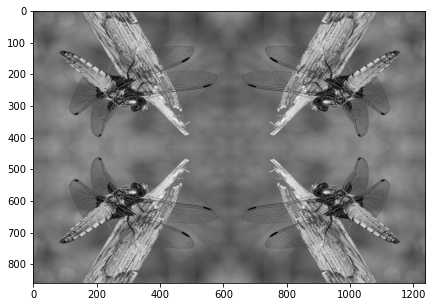

In [300]:
image = color.rgb2gray(plt.imread('dragonfly.jpg'))
timage = np.concatenate((np.fliplr(image),image),axis=1)
timage = np.concatenate((np.flipud(timage),timage),axis=0)
timage = timage[0:-1,0:-1]
print(timage.shape)

plt.figure(figsize=(8,5))
plt.imshow(timage,cmap='gray')

To illustrate that this transformation had the desired effect, we look at the following operation

$$ \hat{x} = \mathcal{F}^{-1}(\mathcal{Re}(\mathcal{F}(x)) $$

In words, we take the Fourier transform, discard the imaginary components, and then take the inverse Fourier transform. The code below implements this for the tiled (symmetric) and untiled (asymmetric) images. Run the code and see the results. Do the results make sense to you?

The result make sense because when the image is asymmetric the FFT is not real but is symmtrical so there might be overlap value with the imaginary value when taking the absolute value. When the image is symmetrical the FFT is real and symmetrical which look right in the titled image.


Text(0.5, 1.0, 'Tiled Image (Symmetric)')

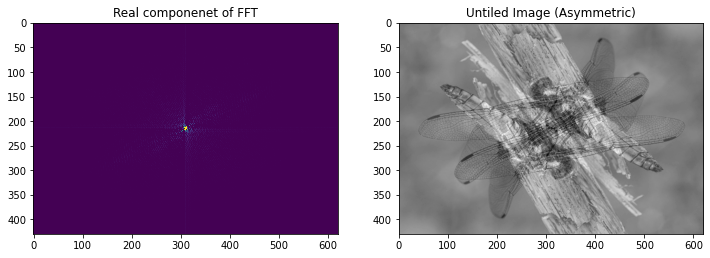

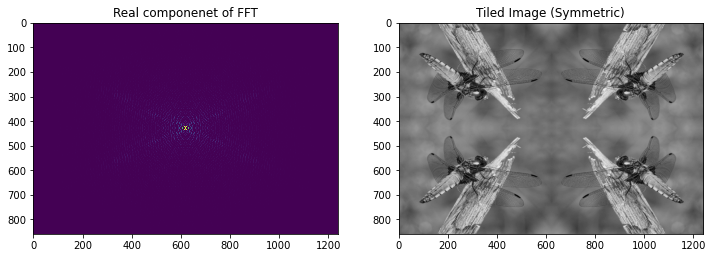

In [301]:
# Untiled Image

f = np.real(fft.fftshift(fft.fft2(image)))
g = np.real(fft.ifft2(fft.ifftshift(f)))

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(f,vmin=0,vmax=500)
plt.title('Real componenet of FFT')

plt.subplot(122)
plt.imshow(np.real(g),cmap='gray')
plt.title('Untiled Image (Asymmetric)')

# Tiled Image
ft = np.real(fft.fftshift(fft.fft2(timage)))
gt = np.real(fft.ifft2(fft.ifftshift(ft)))

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(ft,vmin=0,vmax=500)
plt.title('Real componenet of FFT')

plt.subplot(122)
plt.imshow(np.real(gt),cmap='gray')
plt.title('Tiled Image (Symmetric)')

In the previous step, we eliminated the imaginary component of the FFT, but also doubled the size of the array (Note that the second FFT plot has dimensions that are double those of the first). But we can now use the second property listed above:
- If $x[n]$ is a real signal, then $\mathcal{F}(x[n])$ is symmetric

Here $x[n]$ is our image, which is always real. So the FFT that we obain is symmetric. In practice, this means that we only need to keep one quadrant--we can form the other quadrants by flippling the one have. Let's try it. We will create the tiled FFT in much the same way the we created the tiled image.

Text(0.5, 1.0, 'Cropped Image')

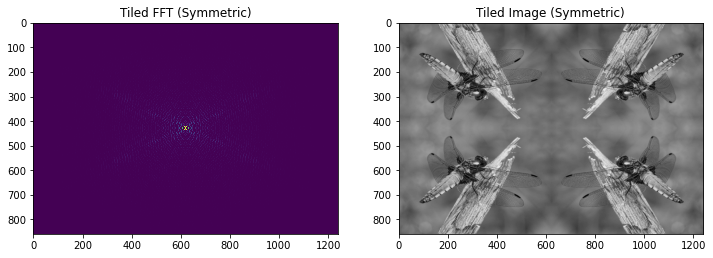

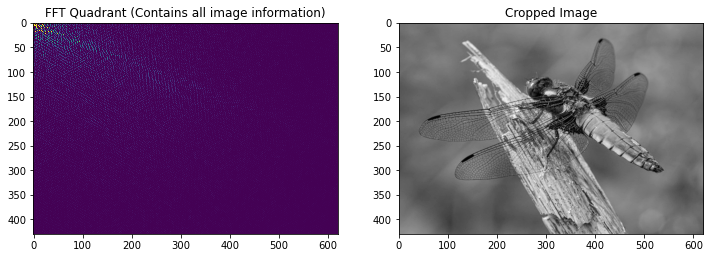

In [302]:
# Extract the lower-right quadrant. 
c = ((np.array(ft.shape))) // 2
fq = ft[c[0]:,c[1]:]

# Tile the quadrant to reconstruct the full FFT
f = np.concatenate((np.fliplr(fq[:,1:]),fq),axis=1)
f = np.concatenate((np.flipud(f[1:,:]),f),axis=0)

g = np.real(fft.ifft2(fft.ifftshift(f)))

# Plot the Tiled Pair
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(f,vmin=0,vmax=500)
plt.title('Tiled FFT (Symmetric)')

plt.subplot(122)
plt.imshow(g,cmap='gray')
plt.title('Tiled Image (Symmetric)')

# Plot the Quadrant Pair

gq = g[c[0]:,c[1]:]

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(fq,vmin=0,vmax=500)
plt.title('FFT Quadrant (Contains all image information)')

plt.subplot(122)
plt.imshow(gq,cmap='gray')
plt.title('Cropped Image')

Thus, we've shown that we can put all of the information from the image into frequency domain representation conaining $m \times n$ *real* elements. And we can do this all using the built-in FFT functionality in python.

Fortunately, there exists a shortcut to what we have just done. Let's assume that we have a symmetric signal, $x[n] = x[-n]$, (perhaps the tiled image that we created above). Then, consider the DFT: 

$$
X_k = \mathcal{F}(x[n]) = \sum_{n=-(N-1)/2}^{(N-1)/2}x[n]e^{-\frac{2\pi}{N}kn} = \sum_{n=-(N-1)/2}^{(N-1)/2}x[n]\left(\cos\left(\frac{2\pi}{N}kn\right)-j \sin\left(\frac{2\pi}{N}kn\right)\right) 
$$

Let's add the terms for negative $n$ to the terms for positive $n$. 

$$
X_k = \sum_{n=0}^{(N-1)/2}x[n]\left(\cos\left(\frac{2\pi}{N}kn\right)-j \sin\left(\frac{2\pi}{N}kn\right)\right) + x[-n]\left(\cos\left(-\frac{2\pi}{N}kn\right)-j \sin\left(-\frac{2\pi}{N}kn\right)\right)
$$

Since both $x[n]$ and the cosine are even, the negatives in the second term go away. Since the sign is odd, the negative transfers through, causing the sine terms to cancel out. This leaves us finally with 

$$
X_k = 2\sum_{n=0}^{(N-1)/2}x[n]\cos\left(\frac{2\pi}{N}kn\right)
$$

This expression and its variants are known as the discrete cosine transform or DCT. The discrete cosine transform is implemented in python, and is useful for real signals such as images. Let's compare the DCT with our result from above.


Text(0.5, 1.0, 'DCT')

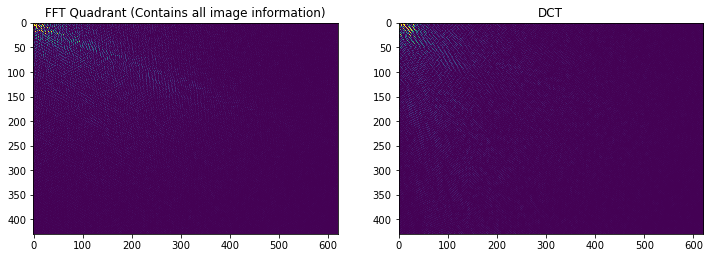

In [303]:
plt.figure(figsize=(12,5))

# Plot the FFT quadrant prepared earlier
plt.subplot(121)
plt.imshow(fq,vmin=0,vmax=500)
plt.title('FFT Quadrant (Contains all image information)')

# Caculate and Plot the DCT
f = fft.dct(fft.dct(image,axis=0),axis=1)

plt.subplot(122)
plt.imshow(f,vmin=0,vmax=500)
plt.title('DCT')

Now that we understand the DCT, we will use it as a tool for image compression.

# 2. Investigating Compression Methods
##  2.1 Method 1: Downsampling and Upsampling
### 2.1.1 In Spatial Domain

In lab 3, we investigated downsampling images by breaking the image into regions and then reducing the information in that region to a single number. In the following example, this is done by taking an average. 

In [304]:
def shrink_average(image, factor):
    """Shrinks an image by a given factor.

    Breaks up the image into (factor x factor) squares and takes the average
    value of the pixels in the square.

    Args:
        image: The image to be shrunk.
        factor: The factor by which to shrink the image.

    Returns:
        The shrunken image.
    """
    segments = np.int_(image.shape) // factor
    result = np.zeros((segments[0], segments[1],3))
    for i in range(0, segments[0]):
        x = int(i * factor)
        for j in range(0, segments[1]):
            y = int(j * factor)
            slice = image[x:x + factor, y:y + factor]
            result[i][j] = slice.mean()

    return result

We also saw that python provided various options for both upsampling and downsampling. In particular, python provides

```python
transform.resize
```

This will be our starting point for considering different approaches to compression. We will see how well we can compress an image by simply downsampling it as our compression step and upsampling as our decompression step. 

After you have reconstructed your image, you can quantify the distortion of the compression method using the root mean square error (RMSE), defined as

$$
RMSE = \sqrt{\sum_{k=1}^N \frac{(x_k, - \hat{x}_k)^2}{N}}
$$

where $x_i$ is a pixel from the original image and $\hat{x}_i$ is a pixel from the decompressed image (the index, $i$, goes over all pixels even though represented here as one dimensional for simplicity. You can imaging unwrapping the image into a 1-d array).

#### Task 2.1
- Load the image
- Use ```transform.resize``` to downsample the image by a factor of two and then up upsample.
- Plot both the original image and the compressed/decompressed image
- Quantify the distortion (error) using the RMSE

In [305]:
# function to calculate RMSE of two images
def RMSE(image, timage):
    return np.sqrt(np.sum((image - timage)**2)/np.size(image))

RMSE =  10.137081794696217


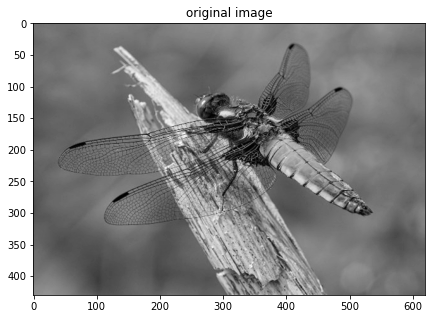

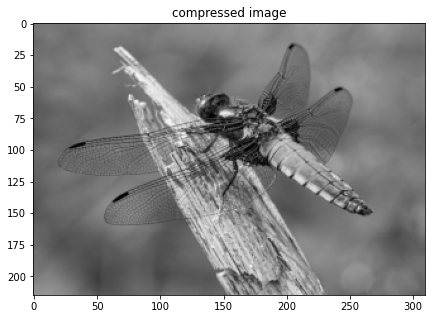

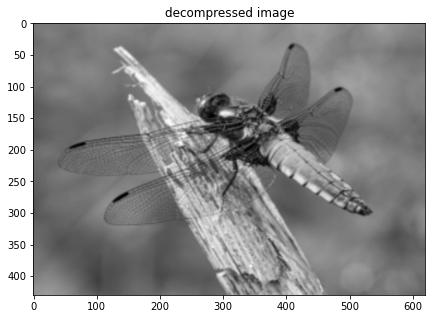

In [306]:
# load dragonfly image
image = np.round(color.rgb2gray(plt.imread('dragonfly.jpg'))*255)

plt.figure(figsize=(12,5))
plt.imshow(image, cmap="gray")
plt.title("original image")
# scaling factor
factor = 2

# compress image by a factor of 2
cimage = transform.resize(image, (image.shape[0]/factor, image.shape[1]/factor))

plt.figure(figsize=(12,5))
plt.imshow(cimage, cmap="gray")
plt.title("compressed image")

# decompress image back to original
dimage = transform.resize(cimage, (cimage.shape[0]*factor, cimage.shape[1]*factor))

plt.figure(figsize=(12,5))
plt.imshow(dimage, cmap="gray")
plt.title("decompressed image")

rmse = RMSE(image, dimage)
print("RMSE = ", rmse)


#### Task 2.2

Now, see how low you can get the RMSE by trying different orders of the interpolation. You can read up on the order by calling.

```python
help(transform.resize)
```

As an example, "order = 1" is a linear interpolation. 

The order has to be in the range 0-5:
 - 0: Nearest-neighbor
 - 1: Bi-linear (default)
 - 2: Bi-quadratic
 - 3: Bi-cubic
 - 4: Bi-quartic
 - 5: Bi-quintic

RMSE (Nearest-neigbor) =  10.137081794696217
RMSE (Bi-cubic) =  8.694178569768182
RMSE (Bi-quartic) =  8.54399242270635
RMSE (Bi-quintic) =  8.616010267357915


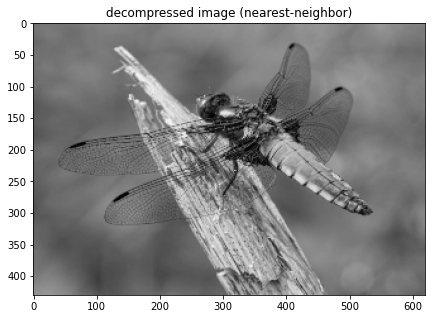

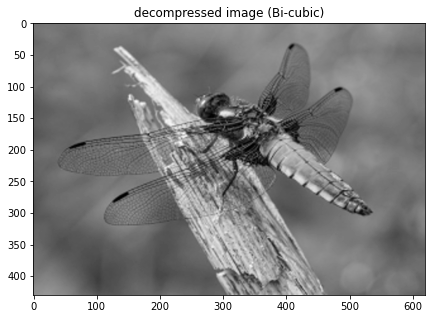

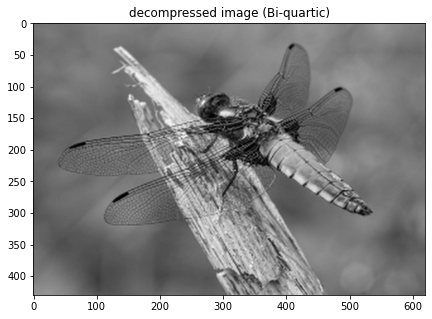

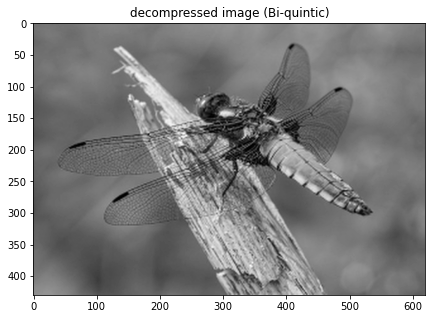

In [307]:
factor = 2

# order=0
cimage0 = transform.resize(image, (image.shape[0]/factor, image.shape[1]/factor), order=0)
dimage0 = transform.resize(cimage0, (cimage0.shape[0]*factor, cimage0.shape[1]*factor), order=0)
plt.figure(figsize=(12,5))
plt.imshow(dimage0, cmap="gray")
plt.title("decompressed image (nearest-neighbor)")

rmse0 = RMSE(image, dimage0)
print("RMSE (Nearest-neigbor) = ", rmse)

# an error saying there is an error in order=2

# order=3
cimage1 = transform.resize(image, (image.shape[0]/factor, image.shape[1]/factor), order=3)
dimage1 = transform.resize(cimage1, (cimage1.shape[0]*factor, cimage1.shape[1]*factor), order=3)
plt.figure(figsize=(12,5))
plt.imshow(dimage1, cmap="gray")
plt.title("decompressed image (Bi-cubic)")

rmse1 = RMSE(image, dimage1)
print("RMSE (Bi-cubic) = ", rmse1)

# order=4
cimage2 = transform.resize(image, (image.shape[0]/factor, image.shape[1]/factor), order=4)
dimage2 = transform.resize(cimage2, (cimage2.shape[0]*factor, cimage2.shape[1]*factor), order=4)
plt.figure(figsize=(12,5))
plt.imshow(dimage2, cmap="gray")
plt.title("decompressed image (Bi-quartic)")

rmse2 = RMSE(image, dimage2)
print("RMSE (Bi-quartic) = ", rmse2)

# order=5
cimage3 = transform.resize(image, (image.shape[0]/factor, image.shape[1]/factor), order=5)
dimage3 = transform.resize(cimage3, (cimage3.shape[0]*factor, cimage3.shape[1]*factor), order=5)
plt.figure(figsize=(12,5))
plt.imshow(dimage2, cmap="gray")
plt.title("decompressed image (Bi-quintic)")

rmse3 = RMSE(image, dimage3)
print("RMSE (Bi-quintic) = ", rmse3)



For a scaled factor of 2, the Bi-quartic interplolation has the lowest RMSE value.

### 2.1.2 In Frequency Domain

Let's see if we can improve upon this performance by doing our upsampling and downsampling in the *frequency domain*.

#### Task 2.3
- Load the image
- Take the DCT
- Downsample and upsample the DCT, and plot both. (Note: when plotting the DCT, use ```plt.imshow(np.abs(f),vmin=0,vmax=500)``` where $f$ is the DCT output. This causes a few of the low frequencies to saturate, but allows the higher frequency content to be visible)
- Take the inverse DCT, and plot the result

Text(0.5, 1.0, 'DCT image')

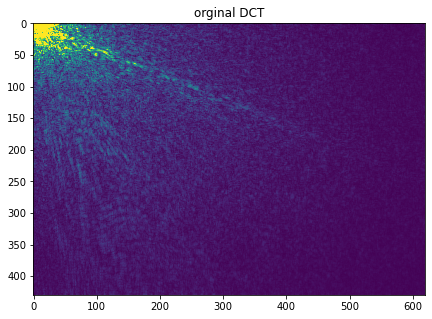

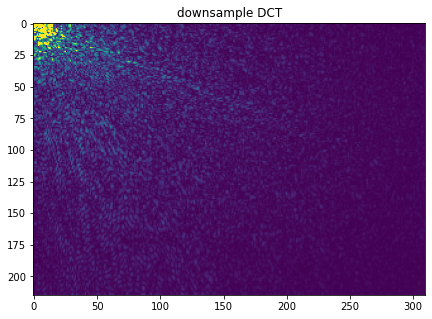

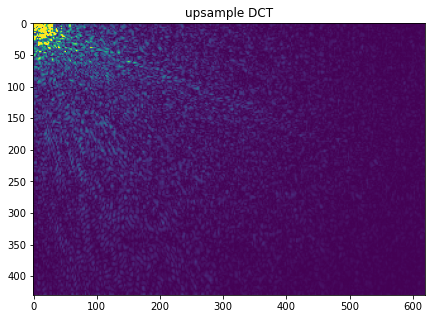

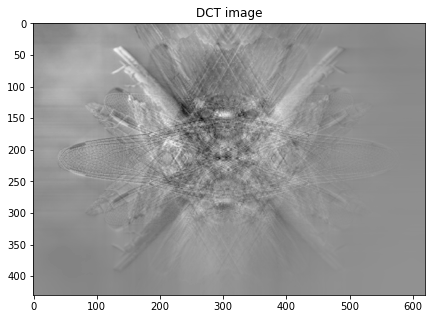

In [308]:
# load dragonfly image
image = color.rgb2gray(plt.imread('dragonfly.jpg'))


factor = 2
# apply DCT
f = fft.dct(fft.dct(image,axis=0),axis=1)
plt.figure(figsize=(12,5))
plt.imshow(np.abs(f), vmin=0, vmax=500)
plt.title("orginal DCT")
          
cf = transform.resize(f, (f.shape[0]/factor, f.shape[1]/factor), order=0)
plt.figure(figsize=(12,5))
plt.imshow(np.abs(cf), vmin=0, vmax=500)
plt.title("downsample DCT")

df = transform.resize(cf, (cf.shape[0]*factor, cf.shape[1]*factor), order=0)
plt.figure(figsize=(12,5))
plt.imshow(np.abs(df), vmin=0, vmax=500)
plt.title("upsample DCT")

newimage = fft.idct(fft.idct(df, axis=0), axis=1)
plt.figure(figsize=(12,5))
plt.imshow(newimage, cmap="gray")
plt.title("DCT image")


The process does not work because downsampling in the frequency domain is similar to sampling. If the signal has frequencies greater than the nyquist rate then we get aliasing. Any of the frequencies above the nyquist rate would be folded on top of the lower frequencies and this casuses the resulting image to appear to be folded as well.  

You'll probably find that this does not work at all. What is happening? Do you understand why your result looks the way it does?

Think of the downsampling operating as comparable to sampling a continuous-time signal. In such a scenario, we've seen that we get "aliasing" when the continuous-time signal has frequencies greater than the nyquist rate (sampling rate divided by 2). In such a case, the original spectrum of the signal would be folded in on itself (any frequencies above the the nyquist rate would be folded in on top of the lower frequencies). 

Given the dual nature of the Fourier transform, this understanding can be extended to the situation here, where we are downsampling in the *frequency* domain and seeing the effects in the *spatial* domain. 

#### Task 2.4
To gain a better understanding of what this means, try looking at the spectra of a downsampled and upsampled iamge, as in Task 2.1. Use ```order=0``` for the downsampling and upsampling.

- Take the DCT of the image and plot.
- Downsample and upsample image using ```order=0```. 
- Take the DCT of the new image and plot.
- Comment on the similarities between what you see here and in Task 2.3 and in your own words, give an explanation of both.

When you downsample and upsample in the frequency domain or the spatial domain then apply the DCT, some of the information (data) in the frequency domain is gone. When we downsample and upsample in the frequency domain, there is half the original data loss when factor is 2. While, downsample and upsample the original image then apply the DCT, the high frequency components are loss because downsample and upsample smooth out the image which act like low-pass filter.

Text(0.5, 1.0, 'image downsampled and upsampled DCT then iDCT')

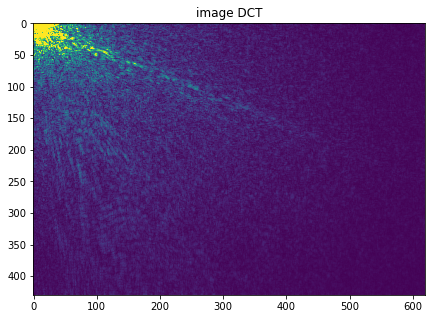

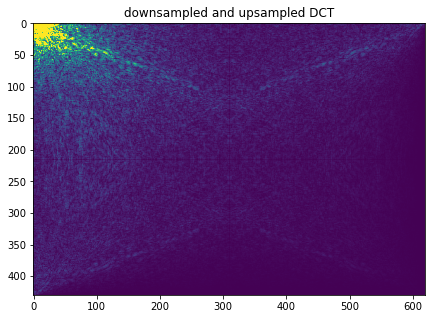

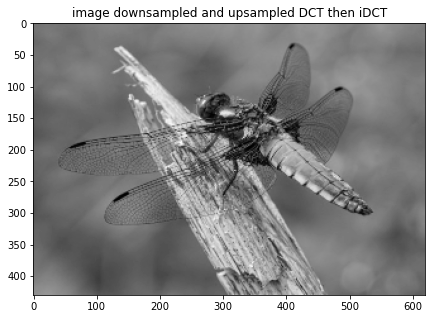

In [315]:
# DCT of image
f = fft.dct(fft.dct(image,axis=0),axis=1)

plt.figure(figsize=(12,5))
plt.imshow(np.abs(f), vmin=0, vmax=500)
plt.title("image DCT")

cimage = transform.resize(image, (image.shape[0]/2, image.shape[1]/2), order=0)
dimage = transform.resize(cimage, (cimage.shape[0]*2, cimage.shape[1]*2), order=0)

df = fft.dct(fft.dct(dimage, axis=0),axis=1) 
plt.figure(figsize=(12,5))
plt.imshow(np.abs(df), vmin=0, vmax=500)
plt.title("downsampled and upsampled DCT")

idf = fft.idct(fft.idct(df, axis=0),axis=1) 
plt.figure(figsize=(12,5))
plt.imshow(idf, cmap="gray")
plt.title("image downsampled and upsampled DCT then iDCT")


## 2.2 Method 2: Quantization

### 2.2.1 In spatial domain
In this class we have studied discrete-time signals, which are signals which have been sampled at discrete times. This represents a departure from continuous-time signals, in which we consider the signals as functions of a continuous time variable. A further departure from the continuous-time case is to consider that the actual value of the signal itself may have only a finite number of discrete values at a given time. 

This is in fact the case for all digital signals, since each point on the signal is represented by a finite number of bits. For example, in the case of imagery, we saw in Lab 3 that each pixel of each color channel might be represented by 8 bits, giving the possibility of 256 values ranging between 0 and 255. 

One possible approach to compression is to further reduce the number of bits used to represent each pixel. In keeping with our approach of the last few sections, we will reduce the number of bits by one half and use 4 bits instead of 8 bits. Note that this only gives us 16 distinct values (0 to 15) to stretch over a range of 0 to 255.

To make the best use of these 16 values, we can use something called gamma compression. This introduces a nonlinearity into the way that we map from the 16 possible values of our 4 bits (represented by $q[i,j]$) to the range of possible values (0 to 255). The gamma compression is written as,

$$
x[i,j] = x_{max}\left(\frac{q[i,j]}{q_{max}}\right)^\gamma
$$

were $x[i,j]$ is the value of the image. We also have the inverse

$$
q[i,j] = q_{max}\left(\frac{x[i,j]}{x_{max}}\right)^{1/\gamma}
$$

Let's plot the relationship for some different values of $\gamma$. (Run the code block)

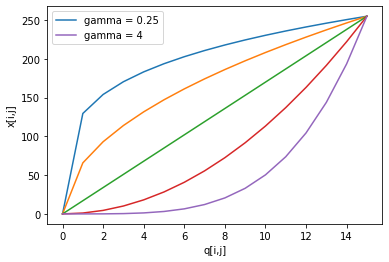

In [316]:
q = np.arange(0,16)
gamma = [0.25,0.5,1,2,4]
q,gamma = np.meshgrid(q,gamma)

x_max = 255
q_max = 15

x = x_max*(q/q_max)**gamma

plt.figure()
lines = plt.plot(x.T);
plt.xlabel('q[i,j]')
plt.ylabel('x[i,j]')
lines[0].set_label('gamma = %g' % 0.25)
lines[-1].set_label('gamma = %g' % 4)
plt.legend()

Observe that the low values of $\gamma$ use the majority of the range of $q$ encoding variations in values (corresponding to *bright* areas of the image), while high values use the majority of the range encoding variations in low values. $\gamma = 1$ is a linear encoding. 

We can try encoding our image with different values of $\gamma$ to see which gives the most visually pleasing result. If $x$ is the image, we can use the following code to compress and decompress

``` python

x = image 
# What are the possible values of each pixel of x (give a range)? How many bits does this require?
# Each pixel has a value between 0-255 and this requires 8 bits.
x_max = 255
q_max = 15

q = np.minimum(np.round(q_max*(x/x_max)**(1/gamma)),q_max) 
# What are the possible values of each pixel of q (give a range)? How many bits does this require?
# each pixel of q has a value between 0-15 and this requires 4 bits.

x = x_max*(q/q_max)**gamma 
# What are the possible values of each pixel of the decompressed image (give a range)? How many bits does this require?
# each pixel of the decompressed image has a value between 0-15 and this requires 4 bits.
```

#### Task 2.5
- Answer the questions in the code snippet above
- Use the code to compress the sample image using different values of gamma (for example, $\gamma = 0.25, 0.5, 1, 2, 4$).
- Calculate and display the RMSE for each
- Additionally, try to find an image for which a $\gamma$ value other than 1 gives better *visual* results than $\gamma = 1$. If you can find such an image, explain why the particular gamma value works well for this image.

gamma=0.25: 45.06819991880044
gamma=0.5: 18.42950476919801
gamma=1: 4.674669593382153
gamma=2: 4.04312016568761
gamma=4: 5.9896888052149775


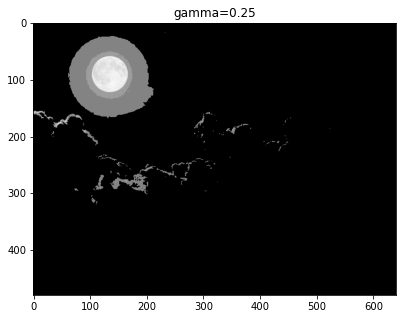

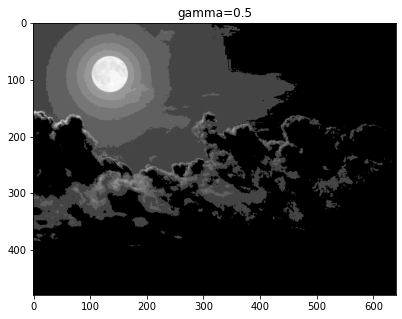

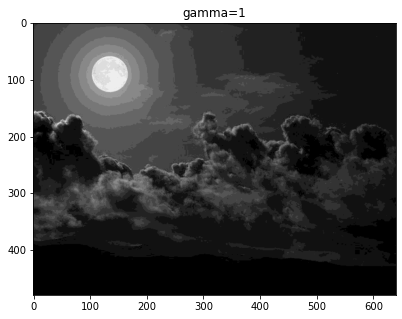

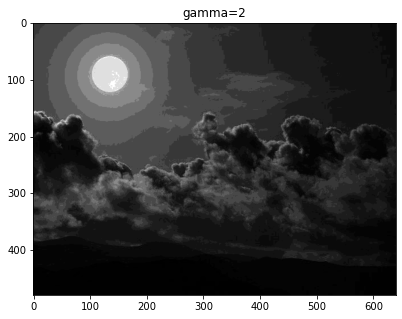

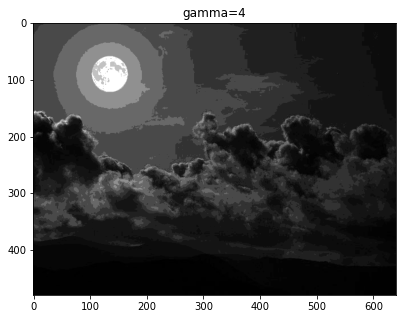

In [317]:
# load birght tree image
image = np.round(color.rgb2gray(plt.imread('night.jpeg'))*255)

# assign x with image (dragonfly.jpg)
# ox - original x
ox = image
x = image
x_max = 255
q_max = 15

# gamma=0.25

gamma = 0.25
q1 = np.minimum(np.round(q_max*(x/x_max)**(1/gamma)),q_max)
x1 = x_max*(q1/q_max)**gamma 
plt.figure(figsize=(12,5))
plt.imshow(x1, cmap="gray")
plt.title("gamma=0.25")
print("gamma=0.25:", RMSE(ox, x1))


gamma = 0.5
q2 = np.minimum(np.round(q_max*(x/x_max)**(1/gamma)),q_max)
x2 = x_max*(q2/q_max)**gamma
plt.figure(figsize=(12,5))
plt.imshow(x2, cmap="gray")
plt.title("gamma=0.5")
print("gamma=0.5:", RMSE(ox, x2))


gamma = 1
q3 = np.minimum(np.round(q_max*(x/x_max)**(1/gamma)),q_max)
x3 = x_max*(q3/q_max)**gamma
plt.figure(figsize=(12,5))
plt.imshow(x3, cmap="gray")
plt.title("gamma=1")
print("gamma=1:", RMSE(ox, x3))

gamma = 2
q4 = np.minimum(np.round(q_max*(x/x_max)**(1/gamma)),q_max)
x4 = x_max*(q4/q_max)**gamma
plt.figure(figsize=(12,5))
plt.imshow(x4, cmap="gray")
plt.title("gamma=2")
print("gamma=2:", RMSE(ox, x4))

gamma = 4
q5 = np.minimum(np.round(q_max*(x/x_max)**(1/gamma)),q_max)
x5 = x_max*(q5/q_max)**gamma
plt.figure(figsize=(12,5))
plt.imshow(x5, cmap="gray")
plt.title("gamma=4")
print("gamma=4:", RMSE(ox, x5))


An image like the "night.jpeg" shown, is darker than the example image so a larger gamma values will use the majority of the range of q encoding variation in low value and better preserve the data of a darker image. As demonstrated above the lowest RMSE value correspond to when gamma=2. Although, a larger gamma would like 4 would encode majorily a dark image but since the "night.jpeg" have some bright spot the encoding is not as effective as gamma value 1 or 2.

### 2.2.2 In frequency domain
We now consider applying the quantization approach in the frequency domain. First, let's take a look at the DCT of our sample image. 

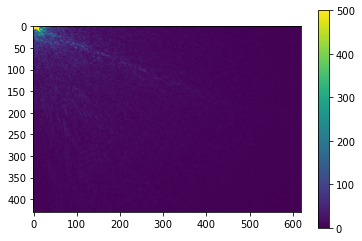

In [318]:
image = np.round(color.rgb2gray(plt.imread('dragonfly.jpg'))*255-128)

f = fft.dct(fft.dct(image,axis=0,norm='ortho'),axis=1,norm='ortho')

plt.figure()
plt.imshow(np.abs(f),vmin=0,vmax = 500)
plt.colorbar()

Notice that the largest values of the DCT are concentrated in the upper-left corner of the image (i.e. in the lower frequencies). As we move toward the higher frequencies, there are fewer and fewer large values. You should try looking at the DCT of a few different images and confirm that this is a general tendency. 

Can you think of how we could make use of this observation to quantize the DCT in an intelligent way? Which frequencies are the most important for the image? Low or high? Which should use the largest number of bits? Can we get away with representing some frequencies with few or no bits? <br> <br>

From observing the frequency domain of a couple images, the majority of the frequencies is low. Based on that pattern we can effectively quantize the DCT by only encoding the low frequencies where the value is greater and require the largest number of bits. We can safely get away with representing higher frequencies with few bit or no bits since they tend to have small or zero values.

One difficulty in performing the quantization in the frequency domain is that the output of the DCT will not typically be in the range of 0 to 255 (Why is this?). In fact, to reduce the large "DC" term of the DCT, we will typically subtract 128 from the image before performing the DCT. Let's see what the largest value of the DCT ends up being after this: <br> <br>
The output of the DCT will not typically be in the range of 0-255 because the value are now frequency which is not bounded by the time domain pixel value. Secondly, images usually have a lot of visual features and variation in pixel which mean high spatial frequency.

In [319]:
f = fft.dct(fft.dct(image,axis=0,norm='ortho'),axis=1,norm='ortho')

print(np.max(np.abs(f)))

6776.402961489902


So we clearly can't perform the quantization as we did before. For each pixel, we will need to decide on three parameters:
- The number of bits to use (to determine $q_{max}$)
- The maximum value to allow ($x_{max}$)
- The gamma factor to use ($\gamma$)

While it would be possible to determine the maximum possible value of the DCT for an image of a particular size and bit depth, using this value may not be optimal. Due to the probabilistic nature of images, it is better to empirically determine parameters which give good results for typical images. 

The following is one way that we might assign the parameters.

Number of bits in Original Image: 2132800
Number of bits in Compressed Image: 533330
Compression Ratio: 0.250061


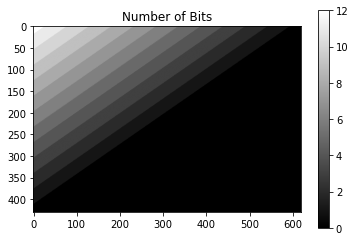

In [320]:
image = np.round(color.rgb2gray(plt.imread('dragonfly.jpg'))*255-128)

# Define the number of bits for each DCT frequency
ny = np.linspace(6,-6,image.shape[0])
nx = np.linspace(6,-6,image.shape[1])
nx,ny = np.meshgrid(nx,ny)
n_bits = np.maximum(np.round(ny+nx),0)

print('Number of bits in Original Image: %d' % (image.size*8))
print('Number of bits in Compressed Image: %d' % np.sum(n_bits))
print('Compression Ratio: %g' % (np.sum(n_bits)/(image.size*8)))

plt.figure()
plt.imshow(n_bits,cmap='gray')
plt.colorbar()
plt.title('Number of Bits')

# Define q_max, f_max, gamma
q_max = 2**n_bits
f_max = 10*q_max # This corresponds to x_max in the spatial case
gamma = 2

Notice that we've first defined the number of bits for each pixel, using the largest number of bits for the most important parts of the DCT. Then, we've defined $q_{max}$, $f_{max}$ using the number of bits. We set $\gamma = 2$ for the entire image. This is just one possible setting. You can experiment with other approaches.


#### Task 2.6
In the previous examples, the compression ratio was easy to determine. For example, if we downsample by a factor of 2, we need half the number of bits to store to compressed image. Likewise, if we quantize from 16 bits to 8 bits. Each of these represents a 50% compression ratio.

Notice that in the above code, we aren't using any bits to encode an entire half of the DCT. Moreover, some of the coefficients in the upper-left portion are encoded using fewer than 8 bits (some more).

- Run the following code and observe the results.
- Determine the compression ratio. How does this compare to previous appraoches? <br>
Using the same method to calculate the compression ratio in section 2.2.2, this approach give a compression ratio of about 0.25. The quantinization method is a big improvement on downsampling because any factor greater than 2 or a compression ratio of 0.5, the downsampled then upsampled image get very blurry while the quantinization method maintain a good image with lower compression ratio.

Number of bits in Original Image: 2132800
Number of bits in Compressed Image: 533330
Compression Ratio: 0.250061
Root Mean square error 3.114016878854909


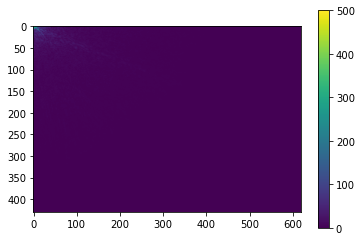

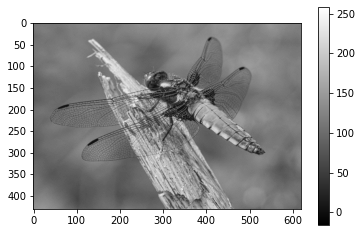

In [321]:
# added parameter getBit,
# so only one print of compression ratio is preformed
# use the same method to get compression ratio as in section 2.2.2
def get_params(shape, getBit=False):
    
    # Define the number of bits for each DCT frequency
    ny = np.linspace(6,-6,shape[0])
    nx = np.linspace(6,-6,shape[1])
    nx,ny = np.meshgrid(nx,ny)
    n_bits = np.maximum(np.round(ny+nx),0)

    # Define q_max, f_max, gamma
    q_max = 2**n_bits
    f_max = 10*q_max # This corresponds to x_max in the spatial case
    gamma = 1.25
    
    if (getBit):
        print('Number of bits in Original Image: %d' % (image.size*8))
        print('Number of bits in Compressed Image: %d' % np.sum(n_bits))
        print('Compression Ratio: %g' % (np.sum(n_bits)/(image.size*8)))
    
    return q_max, f_max, gamma

def compress(image):

    q_max,f_max,gamma = get_params(image.shape, getBit=True)

    # Take the DCT
    f = fft.dct(fft.dct(image-128,axis=0,norm='ortho'),axis=1,norm='ortho')
    
    # Calculate Q
    q = q_max*np.abs(f/f_max)**(1/gamma)

    # Quantize
    q = np.sign(f)*np.round(np.minimum(q,q_max))
    
    return q

def decompress(q):
    
    q_max,f_max,gamma = get_params(q.shape)

    # Reconstruct f from q
    f = np.sign(q)*f_max*np.abs(q/q_max)**gamma
    f[q == 0] = 0

    image = fft.idct(fft.idct(f,axis=0,norm='ortho'),axis=1,norm='ortho')+128
    
    return image

# Load the image  
image = np.round(color.rgb2gray(plt.imread('dragonfly.jpg'))*255)

# Get the compressed DCT
q = compress(image)

plt.figure()
plt.imshow(np.abs(q),vmin=0,vmax=500)
plt.colorbar()

# Get the decompressed image
rimage = decompress(q)
    
plt.figure()
plt.imshow(rimage,cmap='gray')
plt.colorbar()

error = np.sqrt(np.sum((image - rimage)**2)/np.size(image))
print('Root Mean square error %s' % error)

##### Task 2.7
- Create your own ```get_params``` function to define n_bits, q_max, x_max, and gamma. 
- Try to find a combinations that achieves either better compression, better fidelity (less error), or both.

### Quantization map
I wanted to improve on the example linear gradient quantization map by implementing a circular gradient pattern. The circular gradient will focus more on the low frequency in the corner. Also, generally the frequency domain value tends to be along a diagonal, so the cicular gradient pattern will "ignore" the value on the edges. The biggest bit size to encode is 16 bits because this correspond to about the max value in the frequency domain calculated in section 2.2.2 above. The intensity is choosen to be 16 because it produces a quantization map that is good at including low and "middle" frequencies while excluding the high frequencies. The resulting quantization map is a good middle ground for application to any type of image. The gamma value of 1.25 was choosen because due to the nature of most images it tend to be a mix of bright and dark with more leaning toward a little bit more dark. I tested around with a couple images and the value 1.25 seem to work the best. <br> <br>
My get_params implementation is able to achieve a better compression ratio compared to the example with mine being 0.176 and the example is 0.25, tested with dragonfly.jpg image. The RMSE value of my implementation is near identical to the example with mine being 3.127 and the example is 3.114. Overall, I think my implementation is an improvement to the example in term on the compression ratio.

Number of bits in Original Image: 2132800
Number of bits in Compressed Image: 374408
Compression Ratio: 0.175548
Root Mean square error 3.127599379422929


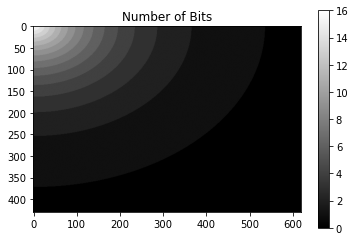

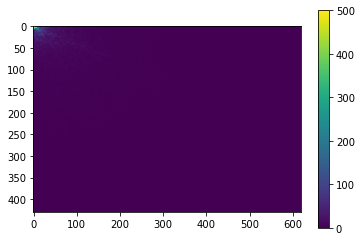

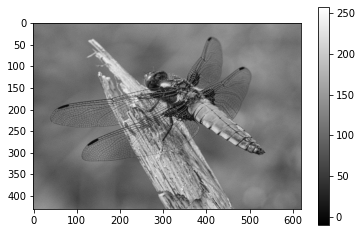

In [322]:
def get_params(shape, getBit=False):
    
    # Define the number of bits for each DCT frequency
    
    # get_params configurations:
    # how concentrated the quantization map on the lower frequency
    # bigger value = high concentration 
    intensity = 16
    
    # amount of bit allocated for value
    # in the frequency domain
    bitAlloc = 16
    
    # create 2D grid(x,y) with value 0-1
    # a scaling square root factor is so
    # the value after applying the circle equation
    # does not get too big
    ny = np.linspace(0,1,shape[0]) * np.sqrt(intensity)
    nx = np.linspace(0,1,shape[1]) * np.sqrt(intensity)
    nx,ny = np.meshgrid(nx,ny)
    
    # create gradient circle pattern
    # use function e^(-x) to have the values be between 0-1
    arr = np.sqrt((nx) ** 2 + (ny) ** 2)
    arr = np.exp(-1*arr) * bitAlloc
    
    # get total bit used
    n_bits = np.maximum(np.round(arr),0)

    if (getBit):
        plt.figure()
        plt.imshow(n_bits,cmap='gray')
        plt.colorbar()
        plt.title('Number of Bits')
        print('Number of bits in Original Image: %d' % (image.size*8))
        print('Number of bits in Compressed Image: %d' % np.sum(n_bits))
        print('Compression Ratio: %g' % (np.sum(n_bits)/(image.size*8)))

    # Define q_max, f_max, gamma
    q_max = 2**n_bits
    f_max = 10*q_max # This corresponds to x_max in the spatial case
    gamma = 1.25
    
    return q_max, f_max, gamma


def compress(image):

    q_max,f_max,gamma = get_params(image.shape, getBit=True)

    # Take the DCT
    f = fft.dct(fft.dct(image-128,axis=0,norm='ortho'),axis=1,norm='ortho')
    
    # Calculate Q
    q = q_max*np.abs(f/f_max)**(1/gamma)

    # Quantize
    q = np.sign(f)*np.round(np.minimum(q,q_max))
    
    return q

def decompress(q):
    
    q_max,f_max,gamma = get_params(q.shape)

    # Reconstruct f from q
    f = np.sign(q)*f_max*np.abs(q/q_max)**gamma
    f[q == 0] = 0

    image = fft.idct(fft.idct(f,axis=0,norm='ortho'),axis=1,norm='ortho')+128
    
    return image

image = np.round(color.rgb2gray(plt.imread('dragonfly.jpg'))*255)

# Get the compressed DCT
q = compress(image)

plt.figure()
plt.imshow(np.abs(q),vmin=0,vmax=500)
plt.colorbar()

# Get the decompressed image
rimage = decompress(q)
    
plt.figure()
plt.imshow(rimage,cmap='gray')
plt.colorbar()

error = np.sqrt(np.sum((image - rimage)**2)/np.size(image))
print('Root Mean square error %s' % error)

## 2.3 Method 3: Best of the both worlds
### Applying frequency domain quantization to local image patches

In the previous section, we found a way to perform frequency domain quantization that worked well for at least one image. Since images come in all different sizes, most actual image compression methods operate on small image patches. 

#### Task 2.8
Your task is to apply the frequency domain quantization to local image patches:
- Find the selection of image patch size and other parameters that give you a favorable compression ratio and RMSE. 
- Quantify the compression ratio that your method achieves. In other words, determine how many bits it would take to store your compressed image compared to the original image.

The following is an example of what your output should look:
![Example](img/compression_example.png)

The patch size is choosen to be 10 (10x10 pixel) because most image resolution are a mutiple of 10. The goal is to apply the patch to all the pixels in the picture since the values will be zero-padded otherwise.

Analyzing:  dragonfly.jpg
Number of bits in Original Image: 2132800
Number of bits in Compressed Image: 410564
Compression Ratio: 0.1925
Root Mean square error 5.405112006483425



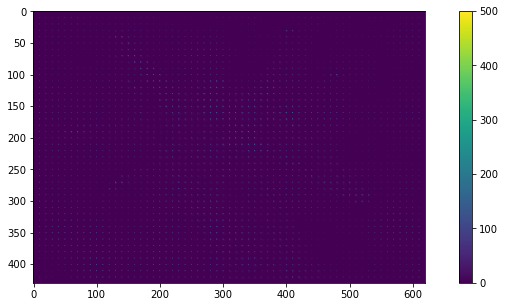

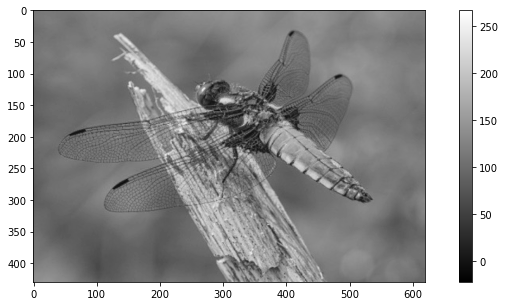

In [323]:
# modified from get_params in Task 2.7 so it will return bit used 
def get_params(shape):
    
    # Define the number of bits for each DCT frequency
    
    # get_params configurations:
    # how concentrated the quantization map on the lower frequency
    # bigger value = high concentration 
    intensity = 16
    
    # amount of bit allocated for value
    # in the frequency domain
    bitAlloc = 16
    
    # create 2D grid(x,y) with value 0-1
    # a scaling square root factor is so
    # the value after applying the circle equation
    # does not get too big
    ny = np.linspace(0,1,shape[0]) * np.sqrt(intensity)
    nx = np.linspace(0,1,shape[1]) * np.sqrt(intensity)
    nx,ny = np.meshgrid(nx,ny)

    # create gradient circle pattern
    # use function e^(-x) to have the values be between 0-1
    arr = np.sqrt((nx) ** 2 + (ny) ** 2)
    arr = np.exp(-1*arr) * bitAlloc
    
    # get total bit used
    n_bits = np.maximum(np.round(arr),0)
    bit = np.sum(n_bits)
    
    # Define q_max, f_max, gamma
    q_max = 2**n_bits
    f_max = 10*q_max # This corresponds to x_max in the spatial case
    gamma = 1.25
    
    return q_max, f_max, gamma, bit


def compress(image):

    q_max,f_max,gamma,bit = get_params(image.shape)

    # Take the DCT
    f = fft.dct(fft.dct(image-128,axis=0,norm='ortho'),axis=1,norm='ortho')

    # Calculate Q
    q = q_max*np.abs(f/f_max)**(1/gamma)

    # Quantize
    q = np.sign(f)*np.round(np.minimum(q,q_max))
    
    return q, bit
    

def decompress(q):
    
    q_max,f_max,gamma, bit = get_params(q.shape)

    # Reconstruct f from q
    f = np.sign(q)*f_max*np.abs(q/q_max)**gamma
    f[q == 0] = 0

    image = fft.idct(fft.idct(f,axis=0,norm='ortho'),axis=1,norm='ortho')+128
    
    return image

# preform compression with a patch size of 10
# print out original image bits, compressed bits
# and compression ratio
# plot the compressed image in the frequency domain
# plot the compressed then decompressed image
def analyzeImage (name):
    print("Analyzing: ", name)
    # load image
    image = np.round(color.rgb2gray(plt.imread(name))*255)
    # patch size
    patch = 10
    # get x and y steps value 
    patchx = int(image.shape[0]/patch)
    patchy = int(image.shape[1]/patch)
    
    # Get the compressed DCT
    q = np.empty([image.shape[0], image.shape[1]]) # zero-pad any value not covered by patch
    bitSum = 0
    for i in range(0,patchx):
        for j in range(0,patchy):
            q[(i*patch):((i+1)*patch), (j*patch):((j+1)*patch)], bit = compress(image[(i*patch):((i+1)*patch), (j*patch):((j+1)*patch)])
            bitSum = bit + bitSum
    
    # plot compressed image in the frequency domain
    plt.figure(figsize=(12,5))
    plt.imshow(np.abs(q),vmin=0,vmax=500)
    plt.colorbar()

    rimage = np.empty([image.shape[0], image.shape[1]]) # zero-pad any value not covered by patch
    # Get the decompressed image
    for i in range(0,patchx):
        for j in range(0,patchy):
            rimage[(i*patch):((i+1)*patch), (j*patch):((j+1)*patch)] = decompress(q[(i*patch):((i+1)*patch), (j*patch):((j+1)*patch)])
    
    # plot image after compression then decompression
    plt.figure(figsize=(12,5))
    plt.imshow(rimage,cmap='gray')
    plt.colorbar()
    
    # display compression stats and RMSE
    print('Number of bits in Original Image: %d' % (image.size*8))
    print('Number of bits in Compressed Image: %d' % bitSum)
    print('Compression Ratio: %g' % (bitSum/(image.size*8)))

    error = np.sqrt(np.sum((image - rimage)**2)/np.size(image))
    print('Root Mean square error %s' % error)
    print()

analyzeImage("dragonfly.jpg")

# 3. Observations and Analysis

#### Task 3.1
Now that you have a functioning compression method which achieves a reasonable compression rate and RMSE, test it out on some different images. See if you can find at least
- One image for which your compression function achieves RMSE lower than for the example image
- One image for which your function achieves RMSE higher than for the example image

For each case, explain why the result makes sense. 

Analyzing:  dragonfly.jpg
Number of bits in Original Image: 2132800
Number of bits in Compressed Image: 410564
Compression Ratio: 0.1925
Root Mean square error 5.405112006483425



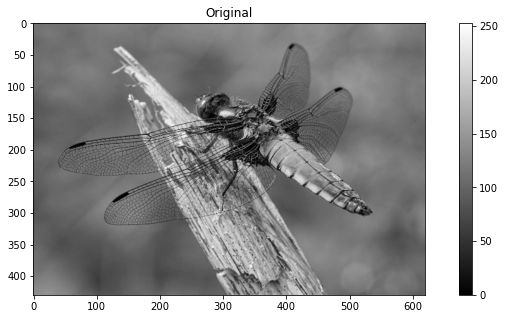

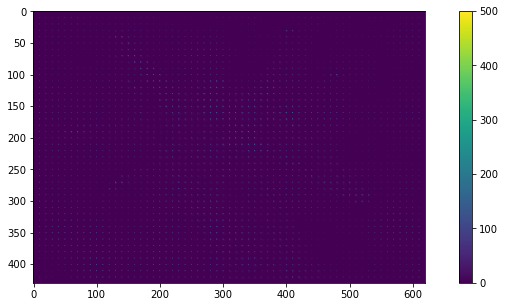

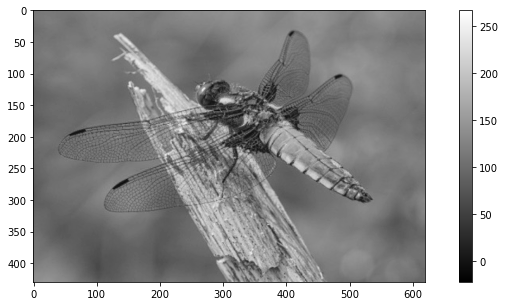

In [324]:
# example image
image = np.round(color.rgb2gray(plt.imread("dragonfly.jpg"))*255)
plt.figure(figsize=(12,5))
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.colorbar()
analyzeImage("dragonfly.jpg")


The quanization map encode mostly the lower frequency, so image like night.jpeg with low spatial frequency will have less data loss during compression. The image night.jpeg have little sharp edges which coresspond to low spatial frequency. As demonstrated below, the RMSE for night.jpeg (1.25) is sufficiently greater than the dragonfly.jpg (5.4) example image with the same compression ratio.

Analyzing:  night.jpeg
Number of bits in Original Image: 2457600
Number of bits in Compressed Image: 473088
Compression Ratio: 0.1925
Root Mean square error 1.2534441138485133



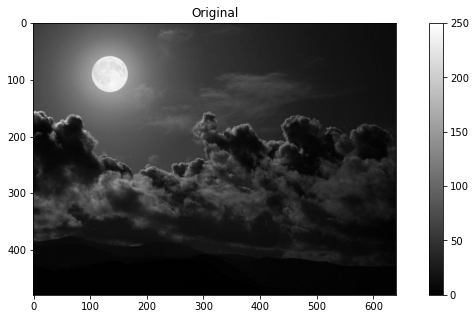

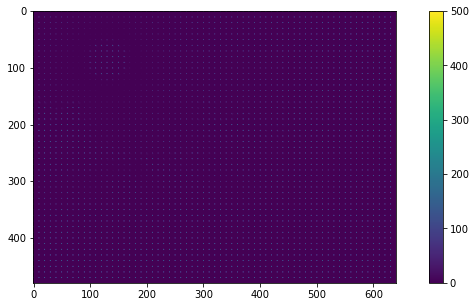

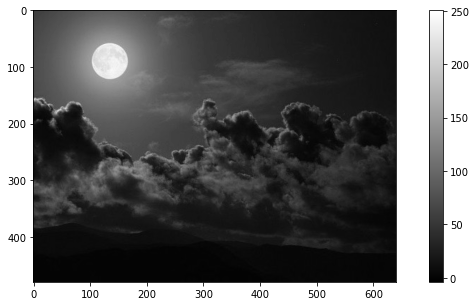

In [325]:
# case when RMSE is higher than the example image
image = np.round(color.rgb2gray(plt.imread("night.jpeg"))*255)
plt.figure(figsize=(12,5))
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.colorbar()
analyzeImage("night.jpeg")


The quanization map encode mostly the lower frequency so image like city.jpeg with high spatial frequency will have some the original data be loss from compression. The image city.jpeg has a lot of sharp edges which corresspond to high spatial frequency. As demonstrated below, the RMSE for city.jpeg (37.3) is significantly greater than the dragonfly.jpg (5.4) example image with the same compression ratio.

Analyzing:  city.jpeg
Number of bits in Original Image: 6195200
Number of bits in Compressed Image: 1192576
Compression Ratio: 0.1925
Root Mean square error 37.31552549736573



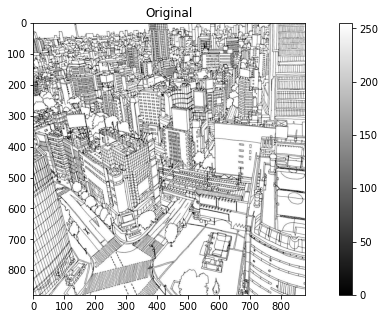

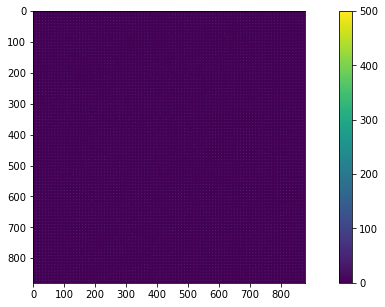

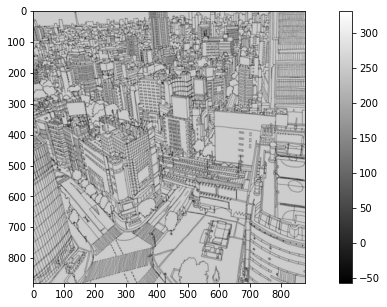

In [326]:
# case when RMSE is higher than the example image
image = np.round(color.rgb2gray(plt.imread("city.jpeg"))*255)
plt.figure(figsize=(12,5))
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.colorbar()
analyzeImage("city.jpeg")


Similar to the image "city.jpeg", the image tree.jpeg has a lot of sharp edges and details in the leaves which corresspond to high spatial frequency. As demonstrated below, the RMSE for tree.jpeg (15.7) is significantly greater than the dragonfly.jpg (5.4) example image with the same compression ratio.

Analyzing:  tree.jpeg
Number of bits in Original Image: 2457600
Number of bits in Compressed Image: 473088
Compression Ratio: 0.1925
Root Mean square error 15.671914220003938



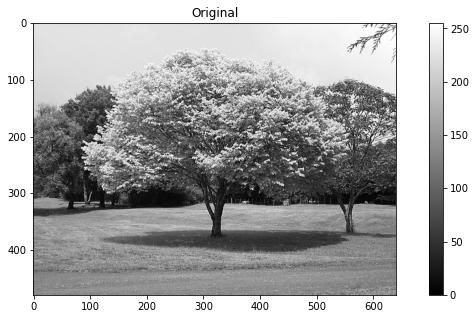

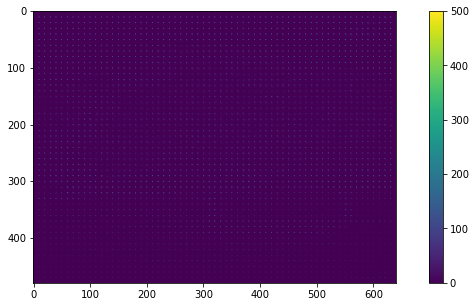

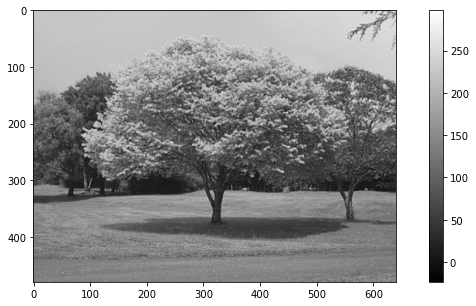

In [327]:
# case when RMSE is lower than the example image
image = np.round(color.rgb2gray(plt.imread("tree.jpeg"))*255)
plt.figure(figsize=(12,5))
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.colorbar()
analyzeImage("tree.jpeg")